In [22]:
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler

datapath = 'resources/globalsales.csv'

def filterdata(df1,output='sales', cat = "all", subcat = "all", market = "all", region = "all" ):
    
    if cat != "all":
        df2 = df1[df1['cat']==cat]
    else:
        df2 = df1
    if subcat != "all":
        df3 = df2[df2['subcat']==subcat]
    else:
        df3 = df2
    if market != "all":
        df4 = df3[df3['market']==market]
    else:
        df4 = df3
    if region != "all":
        df5 = df4[df4['region']==region]
    else:
        df5 = df4
                
    df_filtered = df5.groupby(['date'], as_index = False)["{}".format(output)].sum()
    df_filtered = df_filtered.set_index('date').sort_values(by = 'date')

    return df_filtered


def to_integer(dt_time):
    return (dt_time.year-2016)*12 + dt_time.month

def clean_data(datapath,output='sales', cat = "all", subcat = "all", market = "all", region = "all"):
    df = pd.read_csv(datapath,encoding = "ISO-8859-1")
    df.drop(df.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,25]], axis=1, inplace=True)
    df.columns =['date',"region","market","subcat","cat","sales","quantity","discount","profit","shippingcost"]
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
    df['date'] = df['date'].apply(lambda dt: dt.replace(day=1))
    df_main = df.groupby(['date','region','market','subcat','cat'], as_index = False)['sales','profit','shippingcost'].sum()
    result_df = filterdata(df_main, output=output, cat =cat, subcat =subcat, market =market, region =region)
    return result_df

def forecast_period(year):
    fcst_date = []
    for year in np.arange(2020,year+1):
        for month in np.arange(1,13):
            fcst_date.append(dt.datetime(year,month,1))
    return fcst_date

def return_model(datapath, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):
    
    result_df = clean_data(datapath,output=output, cat =cat, subcat =subcat, market =market, region =region)

    df_diff = result_df.copy()
    df_diff['prev_sales'] = df_diff['sales'].shift(1)
    df_diff['date'] = df_diff.index
    df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])

    #create dataframe for transformation from time series to supervised
    df_supervised = df_diff.drop(['prev_sales'],axis=1)
    #adding lags
    for inc in range(1,13):
        field_name = 'lag_' + str(inc)
        df_supervised[field_name] = df_supervised['diff'].shift(inc)

    #drop null values
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    #import MinMaxScaler and create a new dataframe for LSTM model
    df_model = df_supervised.drop(['sales','date'],axis=1)

    #split train and test set
    train_set, test_set = df_model[0:-12].values, df_model[-12:].values

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

    y_pred = model.predict(X_test,batch_size=1)
    #for multistep prediction, you need to replace X_test values with the predictions coming from t-1

    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(result_df[-13:].index)
    act_sales = list(result_df[-13:].sales)

    for index in range(0,len(pred_test_set_inverted)):
        result_dict = {}
        result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    #for multistep prediction, replace act_sales with the predicted sales

    #merge with actual sales dataframe
    df_sales_pred = pd.merge(result_df,df_result,on='date',how='left')
    plt.plot(df_sales_pred['date'],df_sales_pred['sales'])
    plt.plot(df_sales_pred['date'],df_sales_pred['pred_value'])

def return_forecast(datapath, year = 2021, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):

    result_df = clean_data(datapath,output=output, cat =cat, subcat =subcat, market =market, region =region)

    sum_2017 = result_df[result_df.index.year == 2017] .sum()
    sum_2018 = result_df[result_df.index.year == 2018] .sum()
    sum_2019 = result_df[result_df.index.year == 2019] .sum()

    growth_2018 =  sum_2018 / sum_2017
    growth_2019 =  sum_2018 / sum_2017

    Avg_growth = (growth_2018 + growth_2019)/2

    X_forecast = forecast_period(year)

    for row in X_forecast:
        result_df.loc[row] = result_df.iloc[-12] * Avg_growth

    df_diff = result_df.copy()

    df_diff['prev_sales'] = df_diff['sales'].shift(1)
    df_diff['date'] = df_diff.index
    df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])

    #create dataframe for transformation from time series to supervised
    df_supervised = df_diff.drop(['prev_sales'],axis=1)
    #adding lags
    for inc in range(1,13):
        field_name = 'lag_' + str(inc)
        df_supervised[field_name] = df_supervised['diff'].shift(inc)

    #drop null values
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    #import MinMaxScaler and create a new dataframe for LSTM model
    df_model = df_supervised.drop(['sales','date'],axis=1)

    #split train and test set
    train_set, test_set = df_model[0:-len(X_forecast)].values, df_model[-len(X_forecast):].values

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

    y_pred = model.predict(X_test,batch_size=1)
    #for multistep prediction, you need to replace X_test values with the predictions coming from t-1

    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(result_df[-(len(X_forecast)+1):].index)
    act_sales = list(result_df[-(len(X_forecast)+1):].sales)

    for index in range(0,len(pred_test_set_inverted)):
        result_dict = {}
        result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    #for multistep prediction, replace act_sales with the predicted sales

    #merge with actual sales dataframe
    df_sales_pred = pd.merge(result_df,df_result,on='date',how='left')
    df_sales_pred.iloc[-(len(X_forecast)):,1] = np.nan

    plt.plot(df_sales_pred['date'],df_sales_pred['sales'])
    plt.plot(df_sales_pred['date'],df_sales_pred['pred_value'])
    return df_sales_pred



In [24]:
test_df = return_forecast(datapath = datapath,year = 2024, cat ="Furniture" )

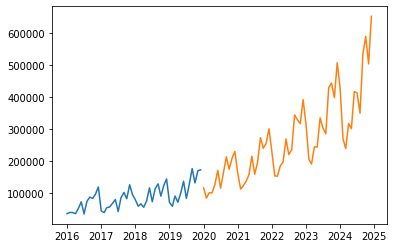

In [27]:
plt.plot(test_df['date'],test_df['sales'])
plt.plot(test_df['date'],test_df['pred_value'])